In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pathlib

# Random seed for reproducability
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import json
# Loading dataset splits from JSON into correct paths for the model
with open(r"C:\Users\wegar\Deadlift Classification v2\splits\v2 split.json", "r") as f:
    splits = json.load(f) # Loads the dictionary of train, test, val clip distribution (only names, not paths)

video_folder = pathlib.Path(r"C:\Users\wegar\Deadlift Classification v2\KPS arrays")

# Filter only R_ occurrences into subsets
subset_paths = {
    split: [video_folder / f"{fname}.npy" for fname in splits[split] if fname.startswith("R_")]
    for split in ["train", "val", "test"]
}

In [15]:
print(f"Train set files: {len(subset_paths['train'])}")
print(f"Val set files: {len(subset_paths['val'])}")
print(f"Test set files: {len(subset_paths['test'])}")

Train set files: 210
Val set files: 42
Test set files: 48


In [16]:
frame_lengths = [np.load(array).shape[0] for array in subset_paths["train"]]

print("Min frames:", min(frame_lengths))
print("Max frames:", max(frame_lengths))
print("Mean frames:", np.mean(frame_lengths))
print("Median frames:", np.median(frame_lengths))


Min frames: 83
Max frames: 289
Mean frames: 191.4952380952381
Median frames: 196.0


In [17]:
idx_to_label = {v: k for k, v in label_dict.items()}
print(idx_to_label)

{0: 'corr', 1: 'oe', 2: 'rb'}


In [3]:
def interpolate_kps(kps, target_frames=200):
    frames, features = kps.shape  # features = 51

    interpolated = np.zeros((target_frames, features), dtype=np.float32)
    for i in range(features):
        interpolated[:, i] = np.interp(
            np.linspace(0, frames - 1, target_frames),
            np.arange(frames),
            kps[:, i]
        )
    return interpolated


unique_labels = set(fname.split("_")[1] for split in splits for fname in splits[split] if fname.startswith("R_"))


label_dict = {label: idx for idx, label in enumerate(sorted(unique_labels))}

def load_data(split):
    X = []
    y = []
    for array in subset_paths[split]:
        kps = np.load(array).reshape(-1, 51)
        kps_interp = interpolate_kps(kps, target_frames=200)
        X.append(kps_interp)

        fname = array.stem  
        label = fname.split("_")[1]
        y.append(label_dict[label])

    y = to_categorical(y, num_classes=len(label_dict)) # One-hot encoding
    return np.array(X), np.array(y)

X_train, y_train = load_data('train')
X_val, y_val = load_data('val')
X_test, y_test = load_data('test')

In [4]:
idx_to_label = {v: k for k, v in label_dict.items()}
print(idx_to_label)

{0: 'corr', 1: 'oe', 2: 'rb'}


In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


optimizer = Adam(learning_rate=1e-4)
verbose, epochs, batch_size = 1, 1000, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(n_timesteps, n_features)),
    LSTM(128),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dense(n_outputs, activation='softmax')
])

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=80,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=10, min_lr=5e-6
)


history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    validation_data = (X_val, y_val),
                    batch_size=batch_size, 
                    callbacks=[early_stop, reduce_lr],
                    verbose=verbose)

Epoch 1/1000
7/7 [==============================] - 4s 205ms/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0873 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 2/1000
7/7 [==============================] - 1s 94ms/step - loss: 1.0950 - accuracy: 0.3857 - val_loss: 1.0812 - val_accuracy: 0.4762 - lr: 1.0000e-04
Epoch 3/1000
7/7 [==============================] - 0s 69ms/step - loss: 1.0854 - accuracy: 0.4095 - val_loss: 1.0773 - val_accuracy: 0.3810 - lr: 1.0000e-04
Epoch 4/1000
7/7 [==============================] - 0s 71ms/step - loss: 1.0884 - accuracy: 0.3714 - val_loss: 1.0720 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 5/1000
7/7 [==============================] - 0s 66ms/step - loss: 1.0952 - accuracy: 0.3476 - val_loss: 1.0612 - val_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 6/1000
7/7 [==============================] - 1s 87ms/step - loss: 1.0760 - accuracy: 0.4143 - val_loss: 1.0511 - val_accuracy: 0.7619 - lr: 1.0000e-04
Epoch 7/1000
7/7 [==============================] -

In [11]:
model.evaluate(X_test, y_test, return_dict=True)

2/2 [==============================] - 0s 46ms/step - loss: 0.4798 - accuracy: 0.8542


{'loss': 0.47982272505760193, 'accuracy': 0.8541666865348816}

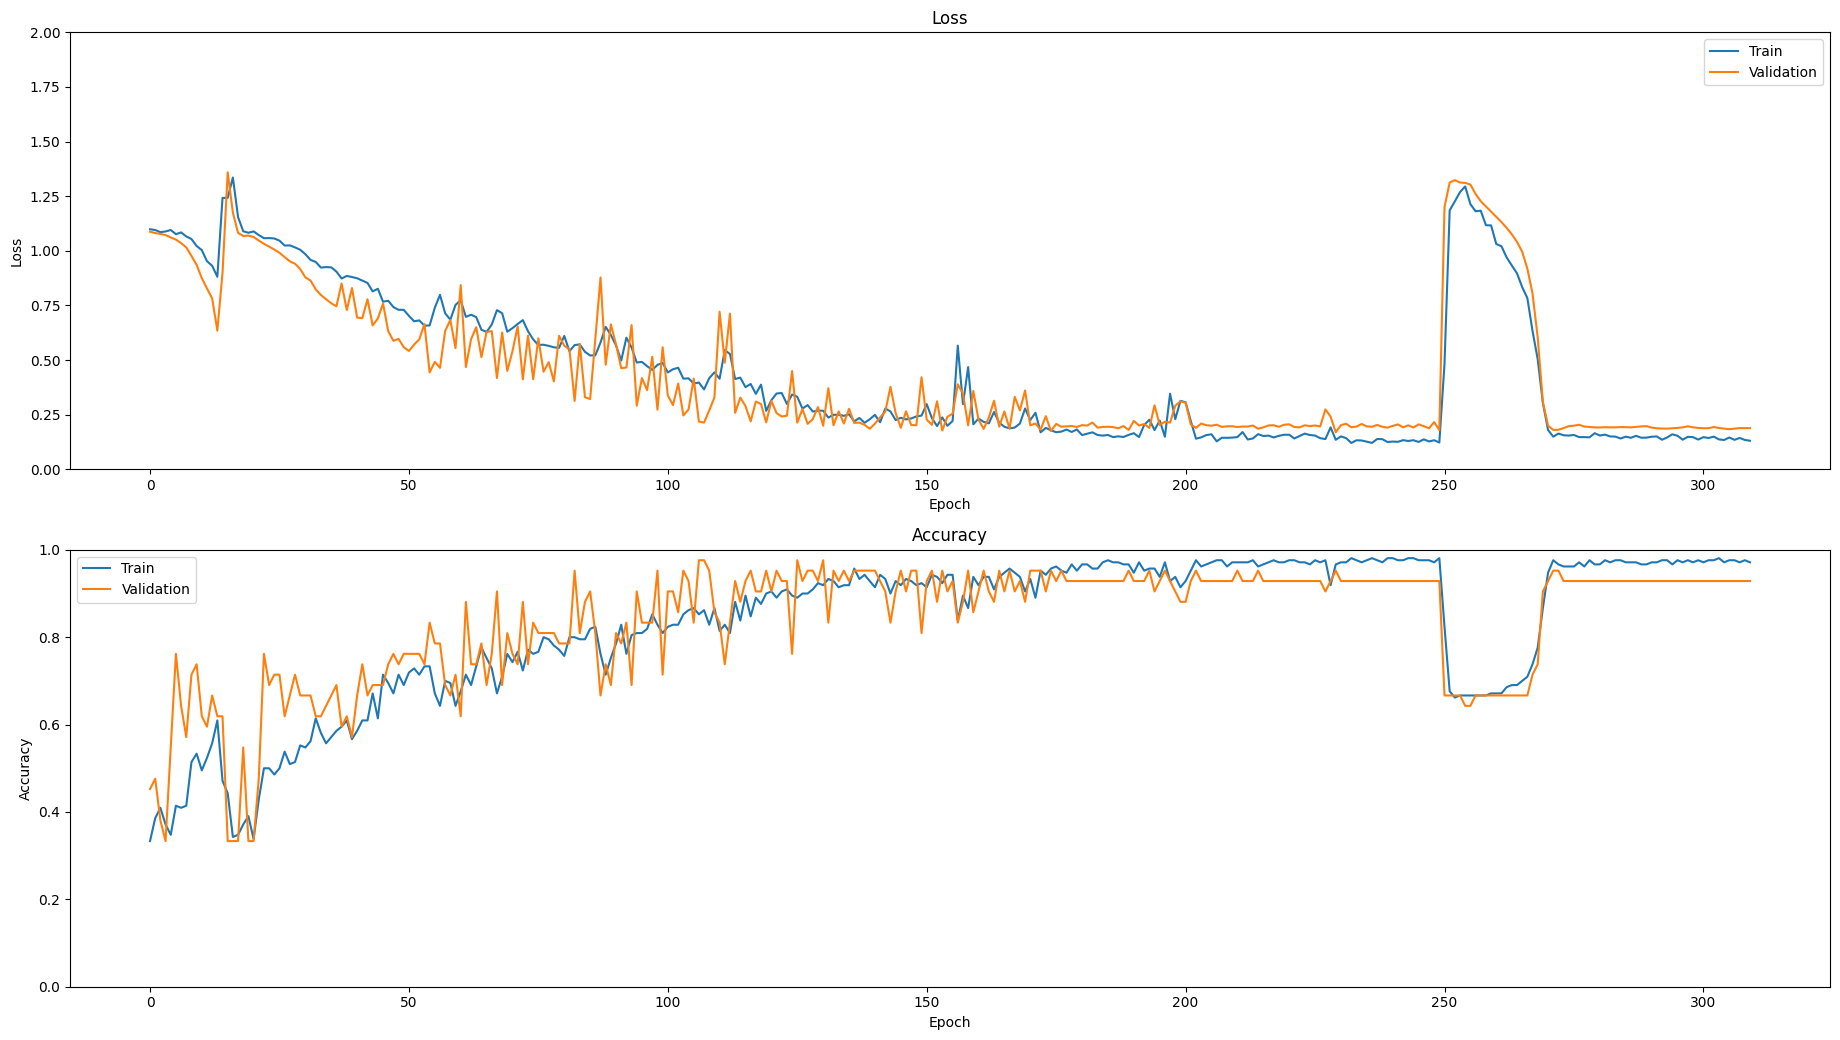

In [12]:
def plot_history(history, imagename=False):
    """
    Plotting training and validation learning curves.
    
    Args:
        history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)
    
    fig.set_size_inches(18.5, 10.5)
    
    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')
    
    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])
    
    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation']) 
    
    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])
    plt.tight_layout()
    if imagename:
        plt.savefig(imagename)
    plt.show()

plot_history(history)

In [13]:
model.save(r"C:\Users\wegar\CNN-LSTM Deadlift Classification\Saved Models\LSTM KPS\Romanian Classifier\LSTM R Classifier.keras")

In [14]:
import pickle
with open(r"C:\Users\wegar\CNN-LSTM Deadlift Classification\Saved Models\LSTM KPS\Romanian Classifier\LSTM R Classifier History.pkl", "wb") as f:
    pickle.dump(history.history, f)